# Dathoven MVP

## Music21 for MIDI

### Goals

- Relative tone
- Relative rythm
- Relative harmony

### Absolute tone

My first aproach is to use absolute tone of notes in order to generate the model.

In [1]:
import glob, os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream,interval

We create a function that takes a midi file and returns all its notes and chords: 


In [3]:
def get_stream_from_midi_without_drums(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    
    for i in range(len(mf.tracks)):
        mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
        

In [4]:
def stream_to_array_of_notes_strings (stream):
    result = []
    for element in stream.flat.notes:
        stringRepresentationOfElement = ''
        if isinstance(element, note.Note):
            stringRepresentationOfElement = element.nameWithOctave
        else: # it's a chord
            listOfNotesWithOctaves = [note.nameWithOctave for note in element.notes]
            stringRepresentationOfElement = ' '.join(listOfNotesWithOctaves)
        result.append(stringRepresentationOfElement)
    return result

In [5]:
def from_midi_to_array_of_notes (midi_path):
    return stream_to_array_of_notes_strings(get_stream_from_midi_without_drums(midi_path))

We create the function that takes an array of notes and chords and creates a midi file:

In [6]:
def from_array_of_elements_to_midi ( elements, midi_path ):
    streamResult = stream.Stream()
    for element in elements:
        if ' ' not in element:
            streamResult.append(note.Note(element))
        else:
            streamResult.append(chord.Chord(element))
    
    streamResult.write('midi', fp= midi_path)

In [7]:
from_array_of_elements_to_midi(["C4", "D4", "E4", "F4", "G4"], "test1.mid")

In [8]:
stream_silent_night = get_stream_from_midi_without_drums("data\examples\silent_night_easy.mid")

In [9]:
from_array_of_elements_to_midi(stream_to_array_of_notes_strings(stream_silent_night), "silent_night.mid")

We create a function that goes trought a folder of midi files reading its notes and chords: 

In [134]:
def get_folder_songs(folder_path):
    songs = []
    for file in glob.glob(folder_path):
        songs.append(from_midi_to_array_of_notes(file))
    return songs

In [135]:
# Test
songs = get_folder_songs("data/examples/*.mid")

We create a dictionary of music elements:

In [136]:
notes_to_number = {}
number_to_note = {}

In [137]:
for song in songs:
    for element in song:
        if not element in notes_to_number:
            number_to_note[len(notes_to_number)+1] = element
            notes_to_number[element] = len(notes_to_number)+1


In [141]:
[notes_to_number[element] for element in songs[0]][:10]

[1, 1, 2, 1, 1, 2, 1, 1, 2, 1]

In [142]:
len(notes_to_number)

481

In [143]:
number_to_note[1]

'C#5'

## Building a MVP

In [144]:
train_set = [[notes_to_number[element] for element in song] for song in songs]

In [145]:
# Training Hyperparameters:
VOCABULARY_SIZE = len(notes_to_number) + 1 # known 0-127 notes + 128 note_off + 129 no_event
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 10
SEED = 2345  # 2345 seems to be good.
np.random.seed(SEED)

Preprocessing data: 

In [146]:
def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
# This slices the melodies into sequences of length SEQ_LEN+1.
# Then, each sequence is split into an X of length SEQ_LEN and a y of length 1.

# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

# Look at the size of the training corpus:
print("Total Training Corpus:")
print("X:", X.shape)
print("y:", y.shape)
print()

# Have a look at one example:
print("Looking at one example:")
print("X:", X[95])
print("y:", y[95])
# Note: Music data is sparser than text, there's lots of 129s (do nothing)
# and few examples of any particular note on.
# As a result, it's a bit harder to train a melody-rnn.

Total Training Corpus:
X: (6915, 30)
y: (6915,)

Looking at one example:
X: [6 1 1 2 1 1 2 1 2 3 3 4 3 3 4 3 3 4 3 3 4 3 1 5 6 5 5 6 5 5]
y: 6


In [251]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

In [148]:
# build the model: 2-layer LSTM network.
# Using Embedding layer and sparse_categorical_crossentropy loss function 
# to save some effort in preparing data.

print('Build model...')
model_train = Sequential()
model_train.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN, mask_zero=True))

# LSTM part
model_train.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_train.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_train.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_train.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_train.summary()

Build model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 256)           123392    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_4 (Dense)              (None, 482)               123874    
Total params: 1,297,890
Trainable params: 1,297,890
Non-trainable params: 0
_________________________________________________________________


In [149]:
# Train the model (this takes time)
history = model_train.fit(X, y, validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS)
#model_train.save("zeldic-rnn.h5")

Train on 6223 samples, validate on 692 samples
Epoch 1/10
6223/6223 [==============================] - 63s 10ms/step - loss: 4.8866 - val_loss: 4.9071
Epoch 2/10
6223/6223 [==============================] - 65s 10ms/step - loss: 4.5637 - val_loss: 4.8427
Epoch 3/10
6223/6223 [==============================] - 67s 11ms/step - loss: 4.3432 - val_loss: 4.7457
Epoch 4/10
6223/6223 [==============================] - 66s 11ms/step - loss: 4.1016 - val_loss: 4.6978
Epoch 5/10
6223/6223 [==============================] - 66s 11ms/step - loss: 3.8521 - val_loss: 4.6571
Epoch 6/10
6223/6223 [==============================] - 66s 11ms/step - loss: 3.6697 - val_loss: 4.7220
Epoch 7/10
6223/6223 [==============================] - 67s 11ms/step - loss: 3.5099 - val_loss: 4.7032
Epoch 8/10
6223/6223 [==============================] - 67s 11ms/step - loss: 3.3619 - val_loss: 4.7048
Epoch 9/10
6223/6223 [==============================] - 67s 11ms/step - loss: 3.1989 - val_loss: 4.6537
Epoch 10/10
6223/

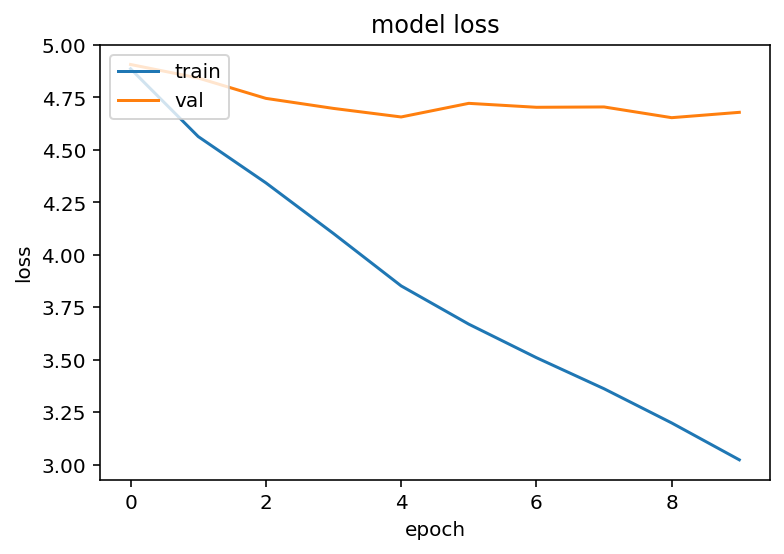

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [151]:
model_train.save("model-weights.h5")

Decoding Model

In [72]:
# Build a decoding model (input length 1, batch size 1, stateful)
model_dec = Sequential()
model_dec.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=1, batch_input_shape=(1,1)))
# LSTM part
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True, return_sequences=True))
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True))

# project back to vocabulary
model_dec.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_dec.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_dec.summary()
# set weights from training model
#model_dec.set_weights(model_train.get_weights())
model_dec.load_weights("model-weights.h5")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, 1, 256)               104960    
_________________________________________________________________
lstm_12 (LSTM)               (1, 1, 256)               525312    
_________________________________________________________________
lstm_13 (LSTM)               (1, 256)                  525312    
_________________________________________________________________
dense_6 (Dense)              (1, 410)                  105370    
Total params: 1,260,954
Trainable params: 1,260,954
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'str' object has no attribute 'decode'

Sample with masking

In [153]:
def sample(preds, temperature=1.0):
    """ helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [154]:
lista = [1,2,3,4,5]
lista.sort(reverse = True)

In [155]:
lista

[5, 4, 3, 2, 1]

In [246]:
from random import randint
def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]
    

In [171]:
randint(0,3)

1

In [247]:
def sample_seq( seq, seq_length, model, number_to_note, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = pad_sequences(input_sequence, maxlen = seq_length, padding="pre")
        prediction = model.predict(x)
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

In [179]:
generated_vector = sample_seq([50], SEQ_LEN, model_train, number_to_note, 50)


In [180]:
generated_notes_and_chords = [number_to_note[number] for number in generated_vector]

In [181]:
from_array_of_elements_to_midi(generated_notes_and_chords, "generated_record_masking.mid")

Sampling


In [89]:
def sample(preds, temperature=1.0):
    """ helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Sampling function

def sample_model(seed, model_name, length=400, temperature=1.0):
    '''Samples a musicRNN given a seed sequence.'''
    generated = []  
    generated.append(seed)
    next_index = seed
    for i in range(length):
        x = np.array([next_index])
        x = np.reshape(x,(1,1))
        preds = model_name.predict(x, verbose=0)[0]
        next_index = sample(preds, temperature)        
        generated.append(next_index)
    return np.array(generated)

In [67]:
o = sample_model(60, model_dec, length=127, temperature=1.0) # generate 8 bars of melody

In [68]:
o

array([ 60, 178, 183, 128, 391, 207,   2, 181, 177,   6, 387, 228,  49,
       105, 201, 223, 285, 359, 320, 277,  44,  87, 321, 331, 254,  42,
       390, 215, 158, 246, 181, 289,  72,  17, 349, 192, 364,  20, 381,
       327, 295,   9, 366, 101, 205, 171,  32, 271, 214,   1, 349, 290,
       318,  35,   9, 144, 187,   0, 311, 319, 408, 290, 319,  44, 164,
       394, 176, 183, 384, 347, 250,   6,  70, 241, 380, 154, 298,  91,
       373, 174,  77,   6, 194, 115, 339, 402, 386, 169, 161, 139,  80,
       345, 276, 294,   5, 405,   7, 326, 143, 278, 101, 363, 187, 306,
       104, 248,  22,  65, 142,  73, 362, 276, 196, 308, 396, 202,   5,
       333, 197,  41, 398, 248, 165,  60, 156, 243, 289, 358], dtype=int64)

In [69]:
generated_notes_and_chords = [number_to_note[number] for number in o]

In [70]:
from_array_of_elements_to_midi(generated_notes_and_chords, "generated_record.mid")

Variable length input

In [76]:
# Build a decoding model (input length 1, batch size 1, stateful)
model_dec = Sequential()
model_dec.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=None, batch_input_shape=(1, None,  1)))
# LSTM part
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True, return_sequences=True))
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True))

# project back to vocabulary
model_dec.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_dec.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_dec.summary()
# set weights from training model
#model_dec.set_weights(model_train.get_weights())
model_dec.load_weights("model-weights.h5")

ValueError: Input 0 is incompatible with layer lstm_17: expected ndim=3, found ndim=4

## Relative tone

We want to transform a song to a series of semitone jumps, in this way we standarize songs so the model learns the relationship between notes instead of their absolute pitch.

In [201]:
def stream_to_array_of_notes_strings (stream):
    result = []
    for element in stream.flat.notes:
        stringRepresentationOfElement = ''
        if isinstance(element, note.Note):
            stringRepresentationOfElement = element.pitch.ps
        else: # it's a chord
            stringRepresentationOfElement = [note.pitch.ps for note in element.notes][0]
            #stringRepresentationOfElement = ' '.join(listOfNotesWithOctaves)
        result.append(stringRepresentationOfElement)
    return result

In [202]:
def from_midi_to_array_of_notes (midi_path):
    return stream_to_array_of_notes_strings(get_stream_from_midi_without_drums(midi_path))

In [206]:
def from_pitches_to_intervals (array_of_pitches):
    intervals = []
    for i in range(1,len(array_of_pitches) - 1):
        intervals.append(array_of_pitches[i] - array_of_pitches[i-1])
    return intervals

In [208]:
def from_midi_to_array_of_intervals(midi_path):
    return from_pitches_to_intervals(from_midi_to_array_of_notes(midi_path))

In [209]:
def get_folder_songs_intervals(folder_path):
    songs = []
    for file in glob.glob(folder_path):
        songs.append(from_midi_to_array_of_intervals(file))
    return songs

In [210]:
from_midi_to_array_of_intervals('data/examples/silent_night_easy.mid')[:5]

[-7.0, 9.0, -2.0, -3.0, 3.0]

In [222]:
def from_array_of_intervals_to_pitches (root_pitch, intervals):
    pitches = [root_pitch]
    for interval in intervals:
        pitches.append(pitches[-1] + interval)
    return pitches

In [224]:
def from_pitches_to_midi (pitches, midi_path):
    streamResult = stream.Stream()
    for pitch in pitches:
            streamResult.append(note.Note(pitch))
            
    streamResult.write('midi', fp= midi_path)

In [225]:
def from_intervals_to_midi( root_pitch, intervals, midi_path):
    pitches = from_array_of_intervals_to_pitches(root_pitch, intervals)
    from_pitches_to_midi(pitches, midi_path)

In [227]:
from_intervals_to_midi(60, from_midi_to_array_of_intervals('data/examples/silent_night_easy.mid'),'test_intervals_silent_night.mid') 

In [188]:
from_array_of_elements_to_midi(from_midi_to_array_of_notes('data/examples/silent_night_easy.mid'), 'test_silent_night.mid')

In [228]:
# Test
songs = get_folder_songs_intervals("data/examples/*.mid")

In [231]:
interval_to_number = {}
number_to_interval = {}

In [232]:
for song in songs:
    for element in song:
        if not element in interval_to_number:
            number_to_interval[len(interval_to_number)+1] = element
            interval_to_number[element] = len(interval_to_number)+1

In [233]:
[interval_to_number[element] for element in songs[0]][:10]

[1, 2, 3, 1, 2, 3, 1, 2, 3, 2]

In [234]:
len(interval_to_number)

109

In [235]:
train_set = [[interval_to_number[element] for element in song] for song in songs]

In [236]:
# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

# Look at the size of the training corpus:
print("Total Training Corpus:")
print("X:", X.shape)
print("y:", y.shape)
print()

# Have a look at one example:
print("Looking at one example:")
print("X:", X[95])
print("y:", y[95])
# Note: Music data is sparser than text, there's lots of 129s (do nothing)
# and few examples of any particular note on.
# As a result, it's a bit harder to train a melody-rnn.

Total Training Corpus:
X: (6875, 30)
y: (6875,)

Looking at one example:
X: [ 4  1  2  3  1  2  3  2  4  1  5  6  1  5  6  1  5  6  1  5  6  7  8  9
 10  1  9 10  1  9]
y: 10


In [237]:
# build the model: 2-layer LSTM network.
# Using Embedding layer and sparse_categorical_crossentropy loss function 
# to save some effort in preparing data.

print('Build model...')
model_interval = Sequential()
model_interval.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN, mask_zero=True))

# LSTM part
model_interval.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_interval.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_interval.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_interval.summary()

Build model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 256)           123392    
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_5 (Dense)              (None, 482)               123874    
Total params: 1,297,890
Trainable params: 1,297,890
Non-trainable params: 0
_________________________________________________________________


In [238]:
history = model_interval.fit(X, y,validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS)

Train on 6187 samples, validate on 688 samples
Epoch 1/10
6187/6187 [==============================] - 76s 12ms/step - loss: 4.2093 - val_loss: 4.0961
Epoch 2/10
6187/6187 [==============================] - 71s 12ms/step - loss: 3.9642 - val_loss: 4.0126
Epoch 3/10
6187/6187 [==============================] - 73s 12ms/step - loss: 3.8047 - val_loss: 3.9826
Epoch 4/10
6187/6187 [==============================] - 74s 12ms/step - loss: 3.6604 - val_loss: 3.9558
Epoch 5/10
6187/6187 [==============================] - 73s 12ms/step - loss: 3.4705 - val_loss: 3.8878
Epoch 6/10
6187/6187 [==============================] - 72s 12ms/step - loss: 3.3567 - val_loss: 3.6768
Epoch 7/10
6187/6187 [==============================] - 72s 12ms/step - loss: 3.2039 - val_loss: 3.6514
Epoch 8/10
6187/6187 [==============================] - 73s 12ms/step - loss: 3.0958 - val_loss: 3.5687
Epoch 9/10
6187/6187 [==============================] - 72s 12ms/step - loss: 3.0112 - val_loss: 3.4959
Epoch 10/10
6187/

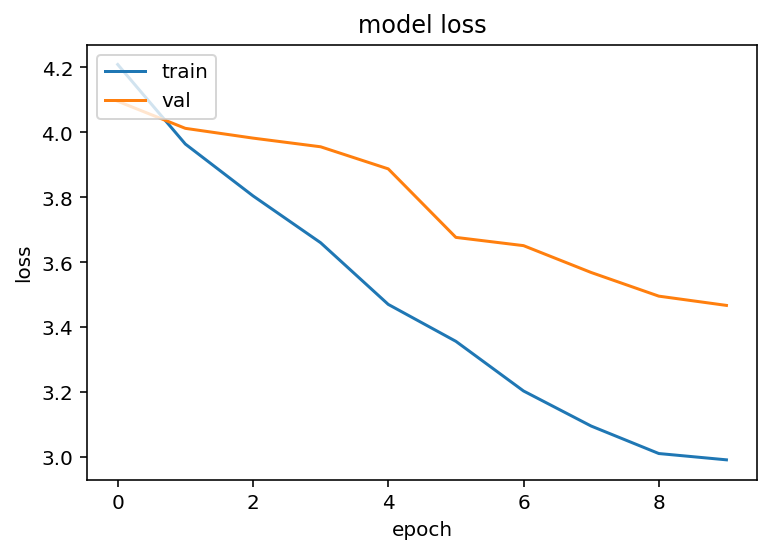

In [239]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [248]:
generated_vector = sample_seq([1], SEQ_LEN, model_interval, number_to_interval, 50)
generated_vector

[1,
 1,
 7,
 1,
 16,
 96,
 33,
 27,
 1,
 33,
 1,
 27,
 33,
 16,
 1,
 19,
 96,
 16,
 1,
 16,
 16,
 19,
 96,
 1,
 7,
 33,
 16,
 19,
 19,
 1,
 16,
 19,
 1,
 16,
 19,
 1,
 96,
 1,
 16,
 19,
 16,
 16,
 16,
 96,
 1,
 16,
 96,
 33,
 16,
 19]

In [249]:
generated_intervals = [number_to_interval[number] for number in generated_vector]
generated_intervals

[0.0,
 0.0,
 -2.0,
 0.0,
 -12.0,
 13.0,
 -24.0,
 24.0,
 0.0,
 -24.0,
 0.0,
 24.0,
 -24.0,
 -12.0,
 0.0,
 12.0,
 13.0,
 -12.0,
 0.0,
 -12.0,
 -12.0,
 12.0,
 13.0,
 0.0,
 -2.0,
 -24.0,
 -12.0,
 12.0,
 12.0,
 0.0,
 -12.0,
 12.0,
 0.0,
 -12.0,
 12.0,
 0.0,
 13.0,
 0.0,
 -12.0,
 12.0,
 -12.0,
 -12.0,
 -12.0,
 13.0,
 0.0,
 -12.0,
 13.0,
 -24.0,
 -12.0,
 12.0]

In [250]:
from_intervals_to_midi(70, generated_intervals,'generated_record_intervals.mid') 

## Partes sueltas:

In [59]:
pitches = [nt.pitch.diatonicNoteNum for nt in notes]
pitches[:12]

NameError: name 'notes' is not defined

In [169]:
intervals = [pitches[i+1] - pitches[i] for i in range(0, len(pitches)-1)]

In [249]:
n_past_notes = 10

X = []
y = []
for i in range(n_past_notes+1, len(intervals)):
    X.append(intervals[i-n_past_notes-1:i-1])
    y.append(intervals[i])


In [250]:
X = np.array(X)
y = np.array(y)

In [251]:
y

array([ -1,  10, -11,  11,  -2,  -9,   0,  10,  -7,   7,  -3,  -4,   5,
        -9,   9,   2, -11,  10,  -1,  -1,  -4,   5,  -1,  -2,  -2,   5,
        -9,   9,   2, -11,  10,  -1,  -1,  -4,   5,  -1,  -2,  -2,  -1,
        -1,  10, -11,  11,   2, -13,  11,  -2,   1,   2,  -9,   7,  -7,
         4,  -2,   2,  -7,   6,  -2,  -1])

In [252]:
y = y + 25*np.ones(len(y))

In [253]:
y

array([24., 35., 14., 36., 23., 16., 25., 35., 18., 32., 22., 21., 30.,
       16., 34., 27., 14., 35., 24., 24., 21., 30., 24., 23., 23., 30.,
       16., 34., 27., 14., 35., 24., 24., 21., 30., 24., 23., 23., 24.,
       24., 35., 14., 36., 27., 12., 36., 23., 26., 27., 16., 32., 18.,
       29., 23., 27., 18., 31., 23., 24.])

In [255]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=50)

In [258]:
X.shape

(59, 10)

In [259]:
n_features = 1

In [260]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [180]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\ten

In [256]:


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_past_notes, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(50))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')


In [261]:
# fit model
model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
59/59 [==============================] - 4s 61ms/sample - loss: 10.6079
Epoch 2/100
59/59 [==============================] - 0s 2ms/sample - loss: 10.2292
Epoch 3/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.5254
Epoch 4/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 5/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 6/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 7/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 8/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 9/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 10/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 11/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 12/100
59/59 [==============================] - 0s 1ms/sample - loss: 7.6493
Epoch 13/1

In [264]:
# demonstrate prediction for next 10 days
x_input = np.array([0,0,0,0,0,0,0,0,0,0,0])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):
    
    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_past_notes, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        yhat = np.argmax(yhat) - 25
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat)
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat)
        i=i+1
    else:
        x_input = x_input.reshape((1, n_past_notes, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

0 day input [0 0 0 0 0 0 0 0 0 0]
0 day output -11
1 day input [  0   0   0   0   0   0   0   0   0 -11]
1 day output -11
2 day input [  0   0   0   0   0   0   0   0 -11 -11]
2 day output -11
3 day input [  0   0   0   0   0   0   0 -11 -11 -11]
3 day output -11
4 day input [  0   0   0   0   0   0 -11 -11 -11 -11]
4 day output -11
5 day input [  0   0   0   0   0 -11 -11 -11 -11 -11]
5 day output -11
6 day input [  0   0   0   0 -11 -11 -11 -11 -11 -11]
6 day output -11
7 day input [  0   0   0 -11 -11 -11 -11 -11 -11 -11]
7 day output -11
8 day input [  0   0 -11 -11 -11 -11 -11 -11 -11 -11]
8 day output -11
9 day input [  0 -11 -11 -11 -11 -11 -11 -11 -11 -11]
9 day output -11
[-11, -11, -11, -11, -11, -11, -11, -11, -11, -11]


In [190]:
lst_output

[0.25244585,
 0.344534,
 0.49337435,
 0.701702,
 0.99891925,
 1.4576102,
 2.1743073,
 3.4265912,
 6.6338954,
 15.217477]

In [265]:
predicted_intervals =np.trunc(np.array(lst_output))
predicted_intervals

array([-11., -11., -11., -11., -11., -11., -11., -11., -11., -11.])

In [266]:
note.Note(pitch.Pitch(0)).show('midi')

In [228]:
stream1 = stream.Stream()

stream1.append(note.Note(pitch.Pitch(30)))

s1 = stream.Stream()
current_pitch = 30
s1.append(note.Note(pitch.Pitch(current_pitch)))
for predicted in predicted_intervals:
    current_pitch = current_pitch + predicted
    s1.append(note.Note(pitch.Pitch(current_pitch)))


In [232]:
s1

<music21.stream.Stream 0x2decc7ebd88>

In [229]:
s1.write('midi', fp='test.mid')

'test.mid'

In [230]:
import pretty_midi
import IPython.display

pm = pretty_midi.PrettyMIDI('test.mid')


In [231]:
IPython.display.Audio(pm.synthesize(fs=1600), rate=1600)

In [21]:
elements[1].offset

68.0

In [25]:
elements[1]

<music21.note.Note C>

In [28]:
elements[2]

<music21.note.Note D>

In [23]:
interval.Interval(elements[1], elements[2]).semitones

2

In [26]:
interval.Interval(elements[2], elements[1]).semitones

-2

In [30]:
bohemian = converter.parse("data\examples\Queen - Bohemian Rhapsody.mid")

In [37]:
bohemian.getInstruments().elements

(<music21.instrument.Instrument ': '>,)

Utilizando https://www.kaggle.com/wfaria/midi-music-data-extraction-using-music21

In [131]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events."data\examples\Queen - Bohemian Rhapsody.mid"
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi("data\examples\silent_night_easy.mid", True)
base_midi

<music21.stream.Score 0x2dea3c60488>

In [132]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Piano


In [133]:
parts = [part for part in base_midi.parts]

In [134]:
[note for note in base_midi.flat.notes][0][0].pitch.ps

TypeError: 'Note' object is not subscriptable

In [135]:
def extract_notes(midi_part):
    notes = []
    offsets = []
    parents =[]
   
    for part in midi_part.parts:     
        for nt in part.flat.notes:
            if isinstance(nt, note.Note):
                notes.append(nt.pitch.ps)
                offsets.append(nt.offset)
                parents.append(part)
            elif isinstance(nt, chord.Chord):
                for pitch in nt.pitches:
                    notes.append(pitch.ps)
                    offsets.append(nt.offset)
                    parents.append(part)
    
    return notes, offsets, parents

In [136]:
song_data = extract_notes(base_midi)


In [137]:
labels = [str(a) for a in song_data[2]]

In [138]:
parts = list(set(labels))

In [139]:
minOffset = 0
maxOffset = 200

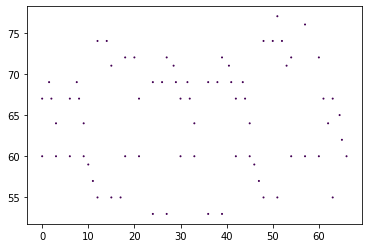

In [140]:
labels = [parts.index(str(part)) for part in song_data[2][minOffset:maxOffset]]
for part in parts:
    plt.scatter(song_data[1][minOffset:maxOffset], song_data[0][minOffset:maxOffset], c=labels, s=1)

Matplotlib is building the font cache; this may take a moment.
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams 

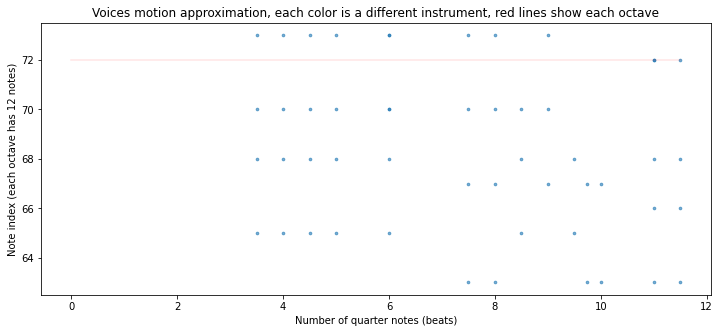

In [42]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>

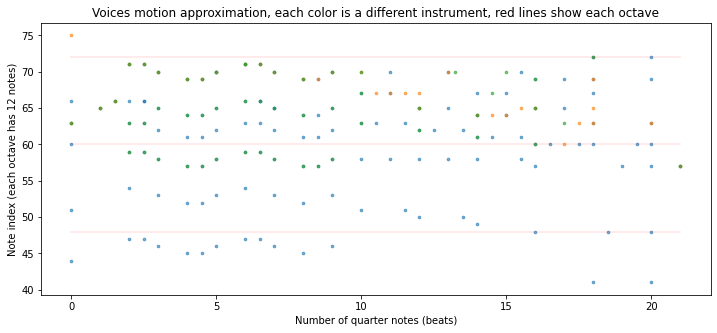

In [43]:
print_parts_countour(base_midi.measures(20, 30))

In [44]:
base_midi.measures(0,1)

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 2 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 1 of 
[None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]
meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>

<music21.stream.Score 0x2debef6a5c8>